# 1. 기술통계항목_확인

In [23]:
import numpy as np
import pandas as pd

In [24]:
churn = pd.read_csv('churn.csv', sep = ',', header = 0)

In [25]:
churn.head()

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


In [26]:
churn.columns = [heading.lower() for heading in
                 churn.columns.str.replace(' ','_').str.replace('\'','').str.strip('?')]

In [27]:
churn['churn01'] = np.where(churn['churn'] == 'True.',1.,0.)

In [28]:
churn.groupby(['churn01'])[['day_charge', 'eve_charge', 'night_charge', 'intl_charge', 'account_length', 'custserv_calls']].agg(['count','mean','std'])

day_charge                       eve_charge                       \
             count       mean        std      count       mean       std   
churn01                                                                    
0.0           2850  29.780421   8.530835       2850  16.918909  4.274863   
1.0            483  35.175921  11.729710        483  18.054969  4.396762   

        night_charge                     intl_charge                      \
               count      mean       std       count      mean       std   
churn01                                                                    
0.0             2850  9.006074  2.299768        2850  2.743404  0.751784   
1.0              483  9.235528  2.121081         483  2.889545  0.754152   

        account_length                       custserv_calls            \
                 count        mean       std          count      mean   
churn01                                                                 
0.0               2850  100.793684  39.88235           2850  1.449825   
1.0                483  102.664596  39.46782            483  2.229814   

                   
              std  
churn01            
0.0      1.163883  
1.0      1.853275

In [29]:
churn.groupby(['churn01']).agg({'day_charge' : ['mean','std'],'eve_charge' : ['mean','std'],
                                'night_charge' : ['mean','std'], 'intl_charge' : ['mean','std'],
                               'account_length' : ['count','min','max'],
                               'custserv_calls' : ['count','min','max']})

day_charge            eve_charge           night_charge            \
              mean        std       mean       std         mean       std   
churn01                                                                     
0.0      29.780421   8.530835  16.918909  4.274863     9.006074  2.299768   
1.0      35.175921  11.729710  18.054969  4.396762     9.235528  2.121081   

        intl_charge           account_length          custserv_calls          
               mean       std          count min  max          count min max  
churn01                                                                       
0.0        2.743404  0.751784           2850   1  243           2850   0   8  
1.0        2.889545  0.754152            483   1  225            483   0   9

## 새로운 독립변수 추가 및 기술툥계항목 확인
* 기존의 독립변수로부터 새로운 독립변수를 추가하여 모델의 성능을 개선할 수 있는지 확인
* 적용 방법(EDA방식으로 접근)
 - 새로운 독립변수에 대한 가설 설정
 - 해당 독립변수에 대한 AB테스트
 - 모델 성능 개선이 있다면 해당 독립변수 활용

In [30]:
churn['total_charges'] = churn['day_charge'] + churn['eve_charge'] + churn['night_charge'] + churn['intl_charge']
# cur함수 => pd.cut(데이터 객체, 구간수, precision =)
# 데이터객체와 구간수는 필수인자
# 구간수: 구간 균등분할 (갯수에 따른 분할은 qcut)
# precision : 소수점 이하 자릿수
factor_cut = pd.cut(churn.total_charges, 5, precision = 2)
def get_stats(group):
    return {'min' : group.min(), 'max' : group.max(), 'count' : group.count(),
           'mean' : group.mean(), 'std' : group.std()}
grouped = churn.custserv_calls.groupby(factor_cut)
print(grouped.apply(get_stats).unstack())

                min  max   count      mean       std
total_charges                                       
(22.86, 37.57]  0.0  5.0    70.0  1.528571  1.348337
(37.57, 52.22]  0.0  7.0   742.0  1.564690  1.305234
(52.22, 66.86]  0.0  9.0  1726.0  1.581692  1.326646
(66.86, 81.51]  0.0  9.0   735.0  1.523810  1.295209
(81.51, 96.15]  0.0  5.0    60.0  1.516667  1.359108


In [34]:
factor_qcut = pd.qcut(churn.account_length, [0., 0.25, 0.5, 0.75, 1.])
grouped = churn.custserv_calls.groupby(factor_qcut)
print(grouped.apply(get_stats).unstack())

                min  max  count      mean       std
account_length                                     
(0.999, 74.0]   0.0  9.0  857.0  1.506418  1.251268
(74.0, 101.0]   0.0  7.0  847.0  1.604486  1.359888
(101.0, 127.0]  0.0  8.0  803.0  1.652553  1.358479
(127.0, 243.0]  0.0  9.0  826.0  1.491525  1.286970


# 2. 로지스틱 회귀분석 

In [35]:
import statsmodels.api as sm

In [37]:
churn = pd.read_csv('churn.csv', sep=',', header=0)
churn.columns = [heading.lower() for heading in churn.columns.str.replace(' ','_').str.replace('\'','').str.strip('?')]
churn['churn'] = np.where(churn['churn'] == 'True.', 1, 0)
churn['total_charges'] = churn['day_charge'] + churn['eve_charge'] + \
						 churn['night_charge'] + churn['intl_charge']
churn['intl_plan'] = np.where(churn['intl_plan'] == 'yes', 1, 0)
churn['vmail_plan'] = np.where(churn['vmail_plan'] == 'yes', 1, 0)

In [38]:
# Fit a logistic regression model
dependent_variable = churn['churn']
independent_variables = churn[['account_length', 'area_code', 'intl_plan', 'vmail_plan', 'vmail_message', 'day_mins', 'day_calls', 'day_charge', 'eve_mins', 'eve_calls', 'eve_charge', 'night_mins', 'night_calls', 'night_charge', 'intl_mins', 'intl_calls', 'intl_charge', 'custserv_calls']]
independent_variables_with_constant = sm.add_constant(independent_variables, prepend =True)
# add_constant 상수항 결합을 위한 함수 => add_constant(독립변수, prepend = True)
logit_model = sm.Logit(dependent_variable, independent_variables_with_constant).fit()

logit_model.summary()

Optimization terminated successfully.
         Current function value: 0.323821
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  churn   No. Observations:                 3333
Model:                          Logit   Df Residuals:                     3314
Method:                           MLE   Df Model:                           18
Date:                Thu, 19 Jan 2023   Pseudo R-squ.:                  0.2174
Time:                        14:30:11   Log-Likelihood:                -1079.3
converged:                       True   LL-Null:                       -1379.1
Covariance Type:            nonrobust   LLR p-value:                9.950e-116
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -8.4417      0.926     -9.118      0.000     -10.256      -6.627
account_length     0.0008      0.001      0.597      0.550      -0.002       0.004
area_code         -0.0005      0.001     -0.363      0.716      -0.003       0.002
intl_plan          2.0456      0.146     14.038      0.000       1.760       2.331
vmail_plan        -2.0251      0.574     -3.527      0.000      -3.150      -0.900
vmail_message      0.0359      0.018      1.992      0.046       0.001       0.071
day_mins          -0.2567      3.275     -0.078      0.938      -6.675       6.162
day_calls          0.0032      0.003      1.159      0.246      -0.002       0.009
day_charge         1.5861     19.263      0.082      0.934     -36.169      39.342
eve_mins           0.7916      1.637      0.483      0.629      -2.418       4.001
eve_calls          0.0011      0.003      0.378      0.705      -0.004       0.007
eve_charge        -9.2280     19.264     -0.479      0.632     -46.985      28.529
night_mins        -0.1127      0.877     -0.128      0.898      -1.832       1.607
night_calls        0.0007      0.003      0.252      0.801      -0.005       0.006
night_charge       2.5860     19.494      0.133      0.894     -35.621      40.793
intl_mins         -4.2874      5.303     -0.809      0.419     -14.681       6.106
intl_calls        -0.0929      0.025     -3.707      0.000      -0.142      -0.044
intl_charge       16.2027     19.639      0.825      0.409     -22.289      54.694
custserv_calls     0.5139      0.039     13.081      0.000       0.437       0.591
==================================================================================
"""

In [68]:
fish_length = [25.4, 26.3, 26.5, 29.0, 29.0, 29.7, 29.7, 30.0, 30.0, 30.7, 31.0, 31.0, 
                31.5, 32.0, 32.0, 32.0, 33.0, 33.0, 33.5, 33.5, 34.0, 34.0, 34.5, 35.0, 
                35.0, 35.0, 35.0, 36.0, 36.0, 37.0, 38.5, 38.5, 39.5, 41.0, 41.0, 9.8, 
                10.5, 10.6, 11.0, 11.2, 11.3, 11.8, 11.8, 12.0, 12.2, 12.4, 13.0, 14.3, 15.0]
fish_weight = [242.0, 290.0, 340.0, 363.0, 430.0, 450.0, 500.0, 390.0, 450.0, 500.0, 475.0, 500.0, 
                500.0, 340.0, 600.0, 600.0, 700.0, 700.0, 610.0, 650.0, 575.0, 685.0, 620.0, 680.0, 
                700.0, 725.0, 720.0, 714.0, 850.0, 1000.0, 920.0, 955.0, 925.0, 975.0, 950.0, 6.7, 
                7.5, 7.0, 9.7, 9.8, 8.7, 10.0, 9.9, 9.8, 12.2, 13.4, 12.2, 19.7, 19.9]

# 2-3 사이킷런 데이터분류_데이터 표준화

In [69]:
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [70]:
np.column_stack(([1,2,3],[4,5,6]))

array([[1, 4],
       [2, 5],
       [3, 6]])

In [71]:
fish_data = np.column_stack((fish_length, fish_weight))

In [72]:
print(fish_data[:5])

[[ 25.4 242. ]
 [ 26.3 290. ]
 [ 26.5 340. ]
 [ 29.  363. ]
 [ 29.  430. ]]


In [73]:
print(np.ones(5))

[1. 1. 1. 1. 1.]


In [74]:
fish_target = np.concatenate((np.ones(35), np.zeros(14)))

In [75]:
print(fish_target)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]


# 사이킷런으로 훈련 세트와 테스트 세트 나누기

In [76]:
from sklearn.model_selection import train_test_split

In [77]:
# sklearn <= 사이킷런, 머신러닝, 데이터 분석 솬련 라이브러리에서 제공
# train_test_split() => 훈련 세트와 테스트 세트로 나누어주는 함수
train_input, test_input, train_target, test_target = train_test_split(fish_data, fish_target, random_state = 42)

In [78]:
print(train_input.shape, test_input.shape)

(36, 2) (13, 2)


In [79]:
print(train_target.shape, test_target.shape)

(36,) (13,)


In [80]:
print(test_target)

[1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [81]:
# 옵션 stratify = [label 데이터] : 훈련셋, 테스트셋에 분류클래스 데이터가 균등하게 배분
train_input, test_input, train_target, test_target = train_test_split(fish_data, fish_target, stratify = fish_target, random_state= 42)

In [82]:
print(test_target)

[0. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1.]


## 수상한 도미 한마리는 빙어로 예측된느 것이 맞는가?

In [83]:
from sklearn.neighbors import KNeighborsClassifier

In [84]:
kn = KNeighborsClassifier()
kn.fit(train_input, train_target)
kn.score(test_input, test_target)

1.0

In [85]:
print(kn.predict([[25,150]]))
# 현재 빙어로 예측됨

[0.]


In [86]:
import matplotlib.pyplot as plt

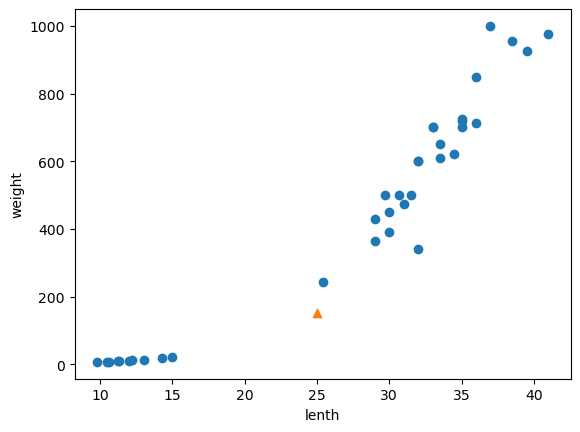

In [87]:
plt.scatter(train_input[:,0], train_input[:,1])
plt.scatter(25,150, marker ='^')
plt.xlabel('lenth')
plt.ylabel('weight')
plt.show()

In [88]:
# KNeighbors([샘플데이터]) => 해당 샘플데이터의 인점한 이웃의 인덱스와 거리를 반환함 (디폴트 5)
distances, indexes = kn.kneighbors([[25,150]])
distances, indexes

(array([[ 92.00086956, 130.48375378, 130.73859415, 138.32150953,
         138.39320793]]),
 array([[21, 33, 19, 30,  1]], dtype=int64))

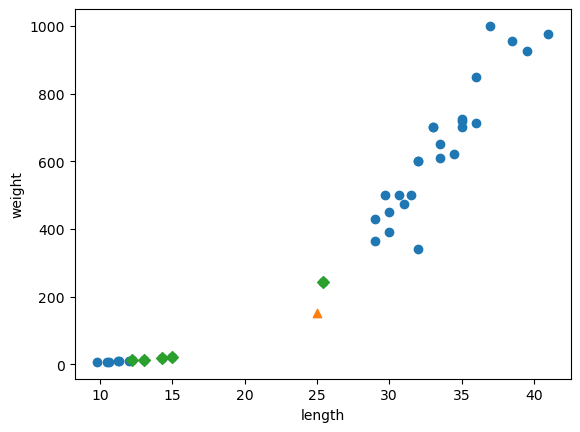

In [92]:
plt.scatter(train_input[:,0], train_input[:,1])
# 검증하고자하는 데이터는 삼각형으로
plt.scatter(25,150, marker ='^')

# 검증 데이터의 인접한 5개 이웃은 다이아몬드로 표시
plt.scatter(train_input[indexes,0], train_input[indexes,1], marker ='D')
plt.xlabel('length')
plt.ylabel('weight')
plt.show()

In [93]:
print(train_input[indexes])

[[[ 25.4 242. ]
  [ 15.   19.9]
  [ 14.3  19.7]
  [ 13.   12.2]
  [ 12.2  12.2]]]


In [94]:
print(train_target[indexes])

[[1. 0. 0. 0. 0.]]


In [95]:
print(distances)

[[ 92.00086956 130.48375378 130.73859415 138.32150953 138.39320793]]


### 위 시각화로 왜 수상한 도미가 빙어로 도출되었는지 알아낼 수 있나?

#### 기준을 맞춰보기

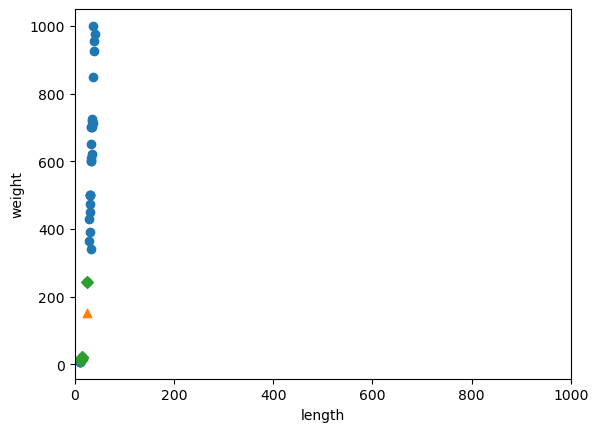

In [97]:
plt.scatter(train_input[:,0],train_input[:,1])
plt.scatter(25,150,marker ='^')
plt.scatter(train_input[indexes,0],train_input[indexes,1], marker = 'D')
plt.xlim((0,1000))
# x축도 y축의 값에 맞게 지정
plt.xlabel('length')
plt.ylabel('weight')
plt.show()

## 데이터 표준화
* 데이터 표준화/정규화 (Data Standardization)
* (특성 - 평균) / 표준편차 => Z 점수